## libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tkinter as tk
from tkinter import messagebox

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
# import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## data loading 

In [2]:
df = pd.read_csv(r"RiskFactorEstimation.csv")
df = df.drop(columns='Unnamed: 0')

# Features & Target
X = df.drop(columns=['breast_cancer_history'])  # Features
y = df['breast_cancer_history']  # Target (0 or 1)
# Rename columns to remove special characters

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  
X_train.columns = [re.sub(r'\W+', '_', col) for col in X_train.columns]
X_test.columns = X_train.columns  # Ensure X_test has the same column names

df

age_group_5_years  race_eth  first_degree_hx  age_menarche  \
0                      8       1.0              0.0           1.0   
1                      9       1.0              0.0           1.0   
2                      5       1.0              1.0           0.0   
3                     10       2.0              0.0           1.0   
4                      5       1.0              0.0           1.0   
...                  ...       ...              ...           ...   
60507                  7       2.0              0.0           0.0   
60508                  2       2.0              0.0           1.0   
60509                  7       1.0              1.0           1.0   
60510                  9       6.0              1.0           1.0   
60511                  7       6.0              0.0           1.0   

       age_first_birth  BIRADS_breast_density  current_hrt  menopaus  \
0                  4.0                    1.0          0.0       2.0   
1                  3.0                    2.0          0.0       2.0   
2                  3.0                    2.0          0.0       1.0   
3                  1.0                    1.0          0.0       2.0   
4                  2.0                    4.0          0.0       1.0   
...                ...                    ...          ...       ...   
60507              2.0                    2.0          0.0       1.0   
60508              2.0                    2.0          0.0       1.0   
60509              0.0                    3.0          0.0       2.0   
60510              2.0                    2.0          0.0       2.0   
60511              2.0                    4.0          0.0       2.0   

       bmi_group  biophx  breast_cancer_history  
0            2.0     0.0                    0.0  
1            1.0     1.0                    0.0  
2            1.0     0.0                    0.0  
3            4.0     0.0                    0.0  
4            1.0     1.0                    0.0  
...          ...     ...                    ...  
60507        3.0     0.0                    0.0  
60508        3.0     0.0                    0.0  
60509        3.0     1.0                    0.0  
60510        2.0     1.0                    0.0  
60511        3.0     0.0                    0.0  

[60512 rows x 11 columns]

he stratify=y ensures that the class distribution in both the training and testing sets mirrors the class distribution in the original dataset.

Without stratification, the split could result in the training or test set having an unrepresentative distribution of the classes, leading to biased model training or evaluation.

For example, if you have 90% of one class and 10% of another class in the original data, using stratify=y ensures that the training and test sets will also have a similar 90-10 split.

In [3]:
print("Original class distribution:", y.value_counts(normalize=True))
print("Training class distribution:", y_train.value_counts(normalize=True))
print("Test class distribution:", y_test.value_counts(normalize=True))

Original class distribution: breast_cancer_history
0.0    0.854227
1.0    0.145773
Name: proportion, dtype: float64
Training class distribution: breast_cancer_history
0.0    0.854221
1.0    0.145779
Name: proportion, dtype: float64
Test class distribution: breast_cancer_history
0.0    0.854251
1.0    0.145749
Name: proportion, dtype: float64


In [4]:
models = {
    'k-NN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(random_state=123),
    'Gradient Boosting': GradientBoostingClassifier(random_state=123),
    'LDA': LinearDiscriminantAnalysis(),
    'Random Forest': RandomForestClassifier(random_state=123),
    'Decision Tree': DecisionTreeClassifier(random_state=123)
   
}

## modeling without balancing 

In [11]:
# Initialize results dictionary
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}

# Define Stratified K-Fold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Evaluate Models
# Evaluate Models
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Cross-validation first
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring=recall_scorer))
    
    # Then fit the model ONCE to the full training data for final testing
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store results
    results['Model'].append(name)
    results['CV_Recall'].append(cv_score)
    results['Test Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Test Precision'].append(precision_score(y_test, y_pred))
    results['Test F1 Score'].append(f1_score(y_test, y_pred))
    
    # Classification report
    model_results[name] = classification_report(y_test, y_pred)


# Convert results to DataFrame and sort by Recall
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization
best_model_name = results_df.iloc[0]['Model']  # Select best model
best_model = models[best_model_name]
best_model.fit(X_train, y_train)


Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...
Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
               Model  CV_Recall  Test Accuracy  Test Precision  Test F1 Score
1        Naive Bayes   0.389402       0.815252        0.370472       0.376464
5      Random Forest   0.188889       0.828885        0.322132       0.211648
6      Decision Tree   0.184071       0.817070        0.275449       0.199566
0               k-NN   0.164092       0.829464        0.321429       0.207373
2           AdaBoost   0.091965       0.851938        0.458824       0.148289
4                LDA   0.090973       0.851111        0.450777       0.161860
3  Gradient Boosting   0.035001       0.853425        0.467949       0.076042


GaussianNB()

## threshold

In [5]:
# Initialize results dictionary
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': [],
    'Test Recall': []  # Add Test Recall to store recall with threshold adjustment
}

# Define Stratified K-Fold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Define threshold for recall tuning (you can experiment with different values, e.g., 0.3, 0.4)
threshold = 0.3

# Evaluate Models
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    model.fit(X_train, y_train)
    
    # Get predicted probabilities instead of hard predictions
    y_prob = model.predict_proba(X_test)[:, 1]  # For binary classification, get probabilities for class 1
    
    # Apply threshold to predictions
    y_pred = (y_prob >= threshold).astype(int)
    
    # Cross-validation (Recall)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring=recall_scorer))
    
    # Calculate metrics with the adjusted threshold
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)  # Recall with threshold adjustment
    
    # Store results
    results['Model'].append(name)
    results['CV_Recall'].append(cv_score)
    results['Test Accuracy'].append(test_accuracy)
    results['Test Precision'].append(test_precision)
    results['Test F1 Score'].append(test_f1)
    results['Test Recall'].append(test_recall)  # Store recall with threshold adjustment
    
    # Store classification report
    model_results[name] = classification_report(y_test, y_pred)

# Convert results to DataFrame and sort by Recall
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization
best_model_name = results_df.iloc[0]['Model']  # Select best model based on cross-validation recall
best_model = models[best_model_name]
best_model.fit(X_train, y_train)


Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...


c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\wae

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
               Model  CV_Recall  Test Accuracy  Test Precision  Test F1 Score  \
1        Naive Bayes   0.389402       0.784599        0.345094       0.418729   
5      Random Forest   0.188889       0.772949        0.297030       0.343840   
6      Decision Tree   0.184071       0.757829        0.277375       0.331585   
0               k-NN   0.168770       0.774767        0.300580       0.347222   
2           AdaBoost   0.091965       0.145749        0.145749       0.254417   
4                LDA   0.090973       0.805420        0.362877       0.399081   
3  Gradient Boosting   0.035001       0.811204        0.378328       0.414853   

   Test Recall  
1     0.532313  
5     0.408163  
6     0.412132  
0     0.410998  
2     1.000000  
4     0.443311  
3     0.459184  


GaussianNB()

In [6]:
results_df = pd.DataFrame(results)

results_df.style.background_gradient(cmap='bwr', axis=0)

ADASYN: Focuses on generating synthetic samples for harder-to-learn examples from the minority class.

ClusterCentroids: Reduces the majority class by creating centroids from its instances.

TomekLinks: Removes the "ambiguous" instances from the majority class that are closest to the decision boundary.

Evaluating with Original...
Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...


c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\wae

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
Evaluating with ADASYN...
Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...


c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\wae

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
Evaluating with ClusterCentroids...
Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...


c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\wae

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
Evaluating with TomekLinks...
Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...


c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\wae

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
                                   Model  CV_Recall  Test Accuracy  \
17  Gradient Boosting - ClusterCentroids   0.931416       0.510121   
19      Random Forest - ClusterCentroids   0.886353       0.527307   
12                Random Forest - ADASYN   0.870404       0.786417   
16           AdaBoost - ClusterCentroids   0.865664       0.591010   
13                Decision Tree - ADASYN   0.845209       0.777824   
10            Gradient Boosting - ADASYN   0.831484       0.761216   
20      Decision Tree - ClusterCentroids   0.818052       0.505495   
8                   Naive Bayes - ADASYN   0.792587       0.644055   
9                      AdaBoost - ADASYN   0.770909       0.760142   
18                LDA - ClusterCentroids   0.746489       0.697513   
15        Naive Bayes - ClusterCentroids   0.742099       0.660332   
14               k-NN - ClusterCentroids   0.736287   

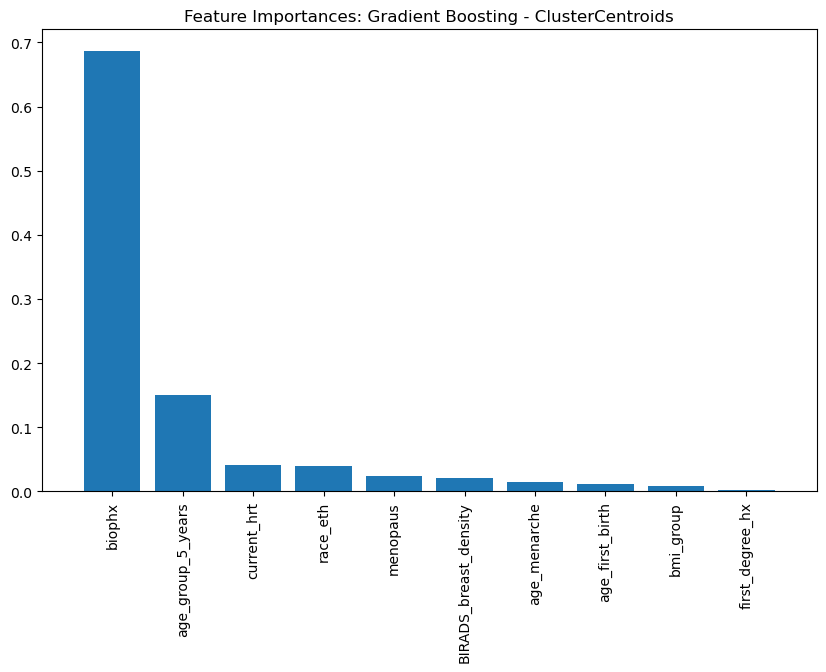

In [7]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids, TomekLinks
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, classification_report
import pandas as pd
import numpy as np

# Initialize results dictionary
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}

# Define Stratified K-Fold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Define resampling methods
resampling_methods = {
    'Original': (X_train, y_train),  # No resampling
    'ADASYN': ADASYN(sampling_strategy='minority', random_state=42),
    'ClusterCentroids': ClusterCentroids(random_state=42),
    'TomekLinks': TomekLinks()
}

# Iterate over resampling methods
for method_name, method in resampling_methods.items():
    print(f"Evaluating with {method_name}...")
    
    # Apply resampling if needed
    if method_name == 'Original':
        X_resampled, y_resampled = X_train, y_train  # No resampling
    else:
        X_resampled, y_resampled = method.fit_resample(X_train, y_train)

    # Evaluate Models with the resampled data
    for name, model in models.items():
        print(f"Evaluating {name}...")
        
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        
        # Cross-validation (Recall)
        cv_score = np.mean(cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring=recall_scorer))
        
        # Store results
        results['Model'].append(f"{name} - {method_name}")
        results['CV_Recall'].append(cv_score)
        results['Test Accuracy'].append(accuracy_score(y_test, y_pred))
        results['Test Precision'].append(precision_score(y_test, y_pred))
        results['Test F1 Score'].append(f1_score(y_test, y_pred))
        
        # Store classification report
        model_results[f"{name} - {method_name}"] = classification_report(y_test, y_pred)

# Convert results to DataFrame and sort by Recall
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization (for the best model based on CV_Recall)
best_model_name = results_df.iloc[0]['Model'].split(" - ")[0]  # Select best model
best_model_method = results_df.iloc[0]['Model'].split(" - ")[1]  # Select best method

print(f"\nBest Model: {best_model_name} with {best_model_method}")
best_model = models[best_model_name]
best_model.fit(X_resampled, y_resampled)

# Plot feature importance (if applicable, e.g., RandomForest)
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title(f"Feature Importances: {best_model_name} - {best_model_method}")
plt.bar(range(X_resampled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_resampled.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_resampled.shape[1]])
plt.show()


In [ ]:
results_df = pd.DataFrame(results)

results_df.style.background_gradient(cmap='bwr', axis=0)

ADASYN + TomekLinks: 
Combining these techniques can help generate synthetic samples for minority class and reduce noise or ambiguous instances.

Threshold Tuning:
The threshold for classifying a sample as the positive class is adjusted to optimize recall. This often results in better performance for imbalanced datasets where recall is crucial (such as in medical applications where false negatives should be minimized).

Evaluating with Original...
Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
Evaluating XGBoost...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Evaluating CatBoost...
Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 7057, number of negative: 41352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 48409, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 5646, number of negative: 33081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 38727, number

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
Evaluating XGBoost...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Evaluating CatBoost...
Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 40364, number of negative: 41257
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 81621, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 32291, number of negative: 33005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 65296, 

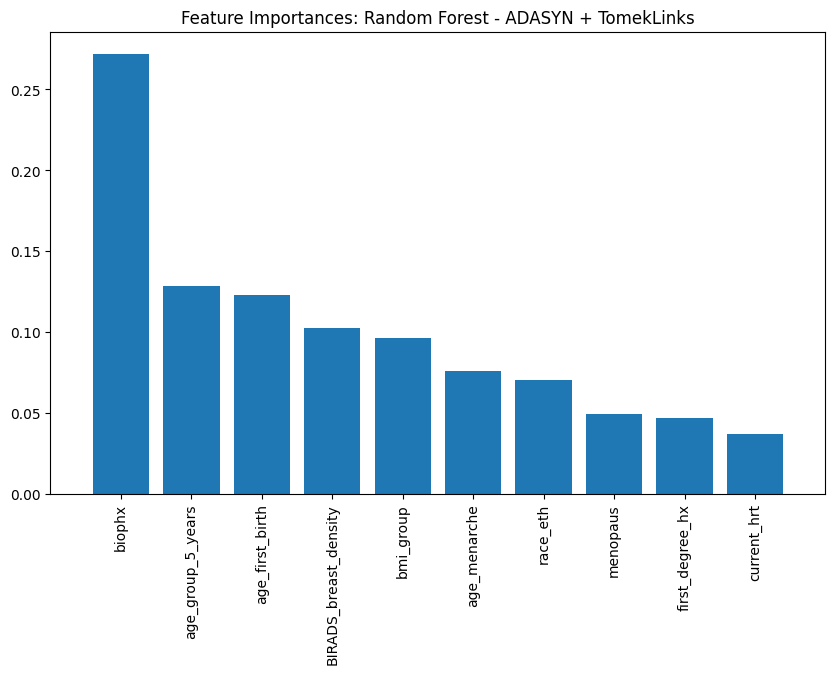

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, classification_report
import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize results dictionary
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}

# Define Stratified K-Fold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Define resampling methods
resampling_methods = {
    'Original': (X_train, y_train),  # No resampling
    'ADASYN + TomekLinks': (ADASYN(sampling_strategy='minority', random_state=42), TomekLinks())
}

# Iterate over resampling methods
for method_name, method in resampling_methods.items():
    print(f"Evaluating with {method_name}...")
    
    # Apply ADASYN to generate synthetic samples
    if method_name == 'ADASYN + TomekLinks':
        adasyn = method[0]
        tomek_links = method[1]
        X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)  # Apply ADASYN first
        X_resampled, y_resampled = tomek_links.fit_resample(X_resampled, y_resampled)  # Apply TomekLinks
    else:
        X_resampled, y_resampled = X_train, y_train  # No resampling

    # Evaluate Models with the resampled data
    for name, model in models.items():
        print(f"Evaluating {name}...")
        
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        
        # Cross-validation (Recall)
        cv_score = np.mean(cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring=recall_scorer))
        
        # Apply threshold tuning to improve recall
        y_prob = model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class
        thresholds = np.linspace(0.1, 0.9, 9)  # Create threshold values from 0.1 to 0.9
        
        best_threshold = 0.5  # Default threshold of 0.5
        best_recall = 0.0
        for threshold in thresholds:
            y_pred_threshold = (y_prob >= threshold).astype(int)
            current_recall = recall_score(y_test, y_pred_threshold)
            if current_recall > best_recall:
                best_recall = current_recall
                best_threshold = threshold
        
        # Re-apply the best threshold to predictions
        y_pred_threshold = (y_prob >= best_threshold).astype(int)
        
        # Store results
        results['Model'].append(f"{name} - {method_name}")
        results['CV_Recall'].append(cv_score)
        results['Test Accuracy'].append(accuracy_score(y_test, y_pred_threshold))
        results['Test Precision'].append(precision_score(y_test, y_pred_threshold))
        results['Test F1 Score'].append(f1_score(y_test, y_pred_threshold))
        
        # Store classification report
        model_results[f"{name} - {method_name}"] = classification_report(y_test, y_pred_threshold)

# Convert results to DataFrame and sort by Recall
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization (for the best model based on CV_Recall)
best_model_name = results_df.iloc[0]['Model'].split(" - ")[0]  # Select best model
best_model_method = results_df.iloc[0]['Model'].split(" - ")[1]  # Select best method

print(f"\nBest Model: {best_model_name} with {best_model_method}")
best_model = models[best_model_name]
best_model.fit(X_resampled, y_resampled)

# Plot feature importance (if applicable, e.g., RandomForest)
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title(f"Feature Importances: {best_model_name} - {best_model_method}")
plt.bar(range(X_resampled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_resampled.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_resampled.shape[1]])
plt.show()


In [ ]:
results_df = pd.DataFrame(results)

results_df.style.background_gradient(cmap='bwr', axis=0)

# ROS

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
import pandas as pd
import numpy as np

# Initialize results dictionary
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}

# Define Stratified K-Fold and scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Apply Random Oversampling on training data
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Evaluate Models
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    model.fit(X_train_ros, y_train_ros)
    y_pred = model.predict(X_test)
    
    # Cross-validation (Recall) on oversampled data
    cv_score = np.mean(cross_val_score(model, X_train_ros, y_train_ros, cv=cv, scoring=recall_scorer))
    
    # Store results
    results['Model'].append(name)
    results['CV_Recall'].append(cv_score)
    results['Test Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Test Precision'].append(precision_score(y_test, y_pred))
    results['Test F1 Score'].append(f1_score(y_test, y_pred))
    
    # Store classification report
    model_results[name] = classification_report(y_test, y_pred)

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train_ros, y_train_ros)


Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
Evaluating XGBoost...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Evaluating CatBoost...
Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 41352, number of negative: 41352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 82704, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 33082, number of negative: 33081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 66163, number of used features: 10
[LightGBM] [Info] [binary:Boost

RandomForestClassifier(random_state=123)

In [ ]:
results_df = pd.DataFrame(results)

results_df.style.background_gradient(cmap='bwr', axis=0)

## random undersampling 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
import pandas as pd
import numpy as np

# Initialize results dictionary
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}

# Define Stratified K-Fold and scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Apply Random Undersampling on training data
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Evaluate Models
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)
    
    # Cross-validation (Recall) on undersampled data
    cv_score = np.mean(cross_val_score(model, X_train_rus, y_train_rus, cv=cv, scoring=recall_scorer))
    
    # Store results
    results['Model'].append(name)
    results['CV_Recall'].append(cv_score)
    results['Test Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Test Precision'].append(precision_score(y_test, y_pred))
    results['Test F1 Score'].append(f1_score(y_test, y_pred))
    
    # Store classification report
    model_results[name] = classification_report(y_test, y_pred)

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train_rus, y_train_rus)


Evaluating k-NN...
Evaluating Naive Bayes...
Evaluating AdaBoost...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Evaluating Gradient Boosting...
Evaluating LDA...
Evaluating Random Forest...
Evaluating Decision Tree...
Evaluating XGBoost...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Evaluating CatBoost...
Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 7057, number of negative: 7057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 14114, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5646, number of negative: 5645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 11291, number of used features: 10
[LightGBM] [Info] [binary:BoostFrom

LGBMClassifier(class_weight='balanced', random_state=42)

In [ ]:
results_df = pd.DataFrame(results)

results_df.style.background_gradient(cmap='bwr', axis=0)

# SMOTE 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
import pandas as pd
import numpy as np

# Initialize results dictionary
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}

# Define Stratified K-Fold and scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Evaluate Models
for name, model in models.items():
    print(f"Evaluating {name} with SMOTE...")
    
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    
    # Cross-validation (Recall) on SMOTE-resampled data
    cv_score = np.mean(cross_val_score(model, X_train_sm, y_train_sm, cv=cv, scoring=recall_scorer))
    
    # Store results
    results['Model'].append(name)
    results['CV_Recall'].append(cv_score)
    results['Test Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Test Precision'].append(precision_score(y_test, y_pred))
    results['Test F1 Score'].append(f1_score(y_test, y_pred))
    
    # Store classification report
    model_results[name] = classification_report(y_test, y_pred)

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train_sm, y_train_sm)


Evaluating k-NN with SMOTE...
Evaluating Naive Bayes with SMOTE...
Evaluating AdaBoost with SMOTE...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Evaluating Gradient Boosting with SMOTE...
Evaluating LDA with SMOTE...
Evaluating Random Forest with SMOTE...
Evaluating Decision Tree with SMOTE...
Evaluating XGBoost with SMOTE...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:12:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Evaluating CatBoost with SMOTE...
Evaluating LightGBM with SMOTE...
[LightGBM] [Info] Number of positive: 41352, number of negative: 41352
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 82704, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 33082, number of negative: 33081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 66163, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore

RandomForestClassifier(random_state=123)

In [ ]:
results_df = pd.DataFrame(results)

results_df.style.background_gradient(cmap='bwr', axis=0)

SMOTE+ENN

In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer
import pandas as pd
import numpy as np

# Initialize results dictionary
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}

# Define Stratified K-Fold and scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Apply SMOTE + ENN on training data
smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

# Evaluate Models
for name, model in models.items():
    print(f"Evaluating {name} with SMOTE + ENN...")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Cross-validation (Recall)
    cv_score = np.mean(cross_val_score(model, X_train_se, y_train_se, cv=cv, scoring=recall_scorer))
    
    # Store results
    results['Model'].append(name)
    results['CV_Recall'].append(cv_score)
    results['Test Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Test Precision'].append(precision_score(y_test, y_pred))
    results['Test F1 Score'].append(f1_score(y_test, y_pred))
    
    # Store classification report
    model_results[name] = classification_report(y_test, y_pred)

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train, y_train)


Evaluating k-NN with SMOTE + ENN...
Evaluating Naive Bayes with SMOTE + ENN...
Evaluating AdaBoost with SMOTE + ENN...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Evaluating Gradient Boosting with SMOTE + ENN...
Evaluating LDA with SMOTE + ENN...
Evaluating Random Forest with SMOTE + ENN...
Evaluating Decision Tree with SMOTE + ENN...
Evaluating XGBoost with SMOTE + ENN...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:14:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:14:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:14:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Evaluating CatBoost with SMOTE + ENN...
Evaluating LightGBM with SMOTE + ENN...
[LightGBM] [Info] Number of positive: 17886, number of negative: 27520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 45406, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 14308, number of negative: 22016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of dat

RandomForestClassifier(random_state=123)

In [ ]:
results_df = pd.DataFrame(results)

results_df.style.background_gradient(cmap='bwr', axis=0)

Evaluating k-NN with SMOTE + ENN...


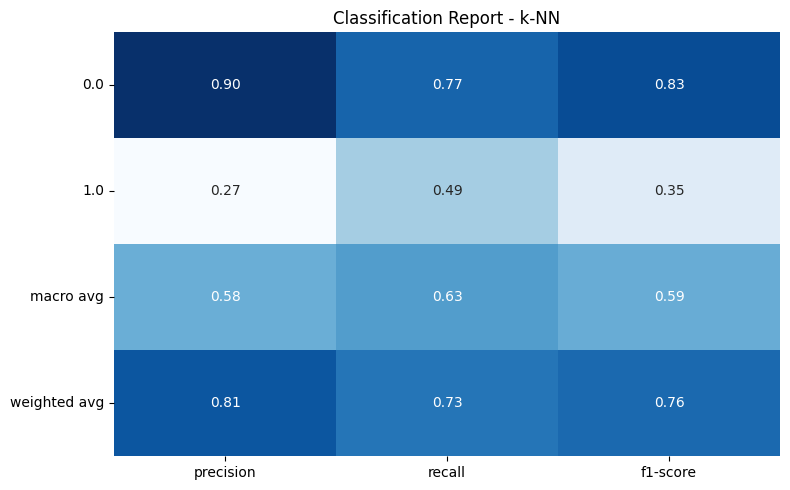

Evaluating Naive Bayes with SMOTE + ENN...


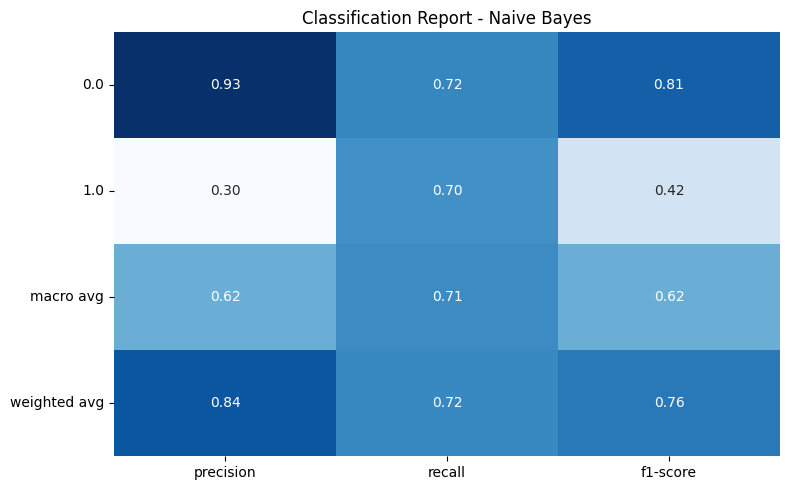

Evaluating AdaBoost with SMOTE + ENN...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

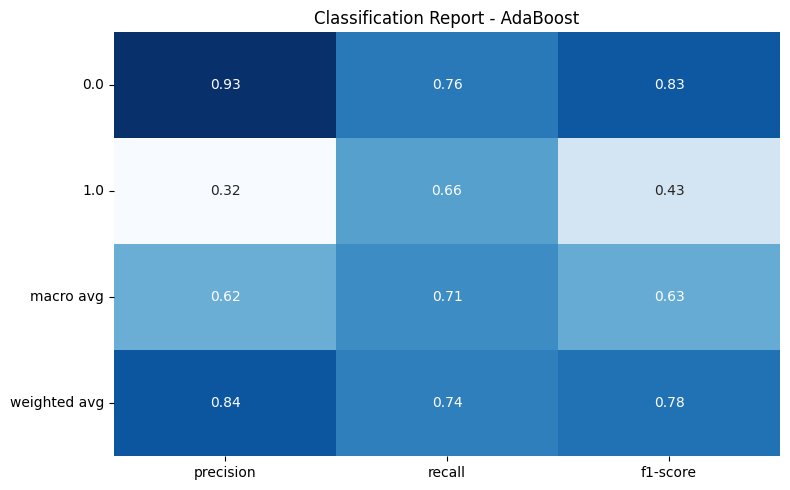

Evaluating Gradient Boosting with SMOTE + ENN...


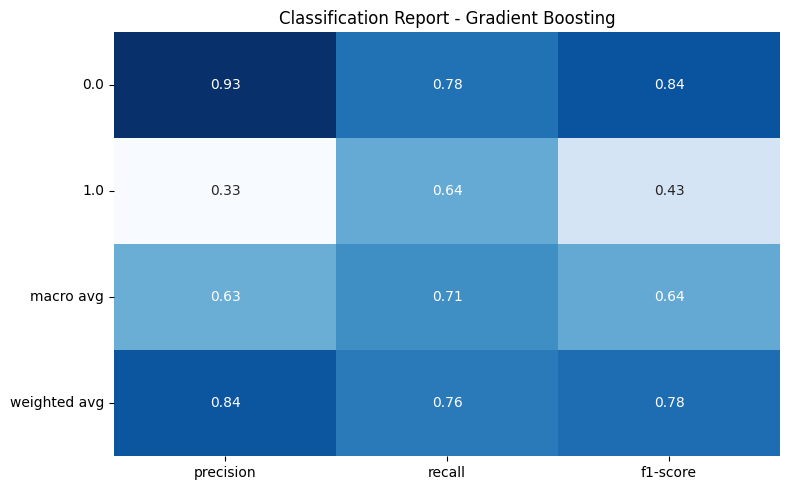

Evaluating LDA with SMOTE + ENN...


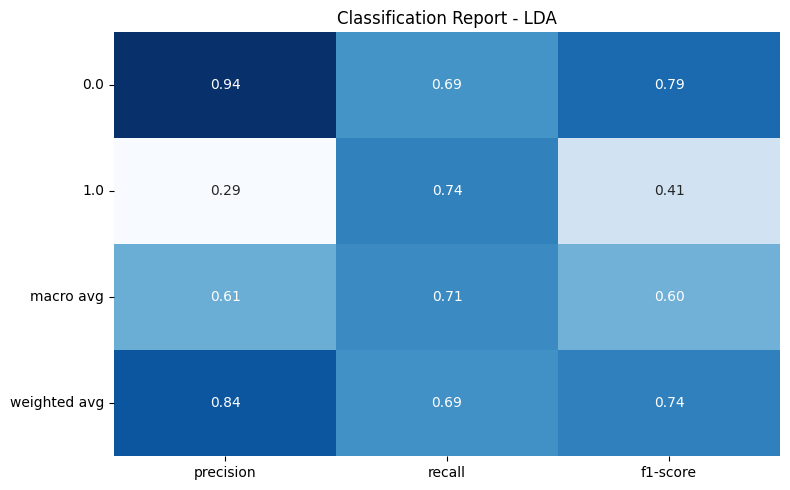

Evaluating Random Forest with SMOTE + ENN...


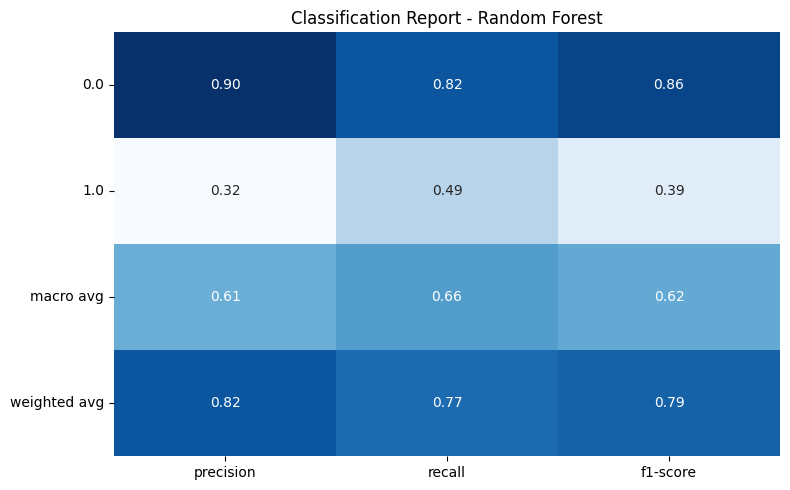

Evaluating Decision Tree with SMOTE + ENN...


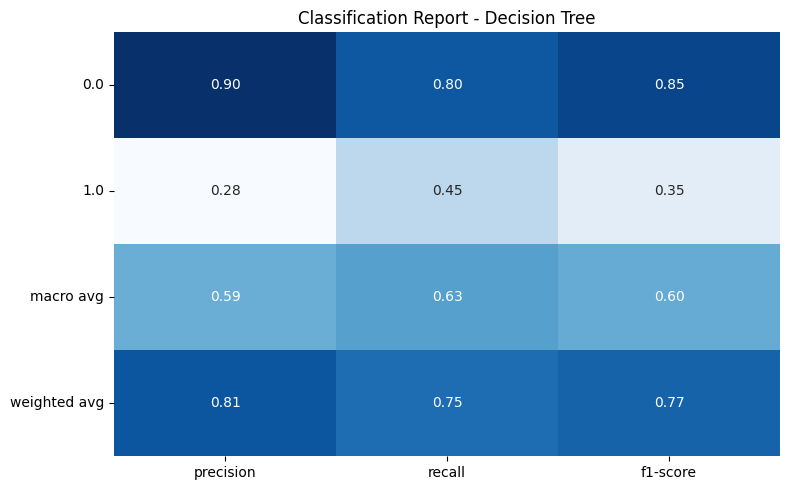

Evaluating XGBoost with SMOTE + ENN...


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

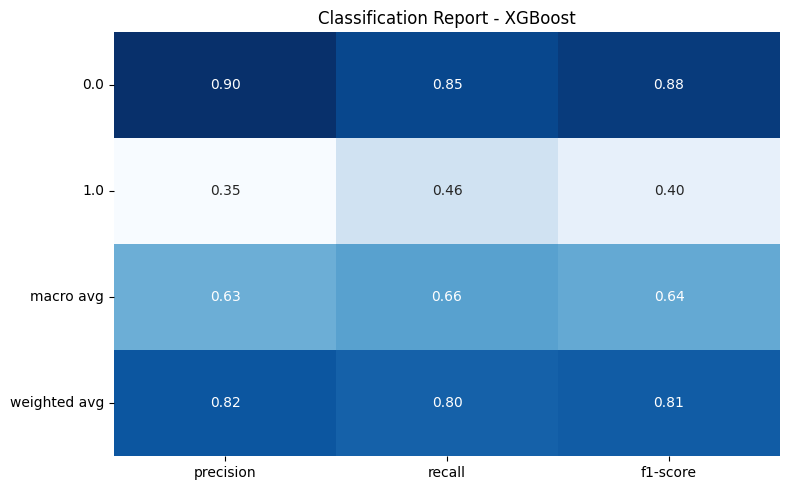

Evaluating CatBoost with SMOTE + ENN...


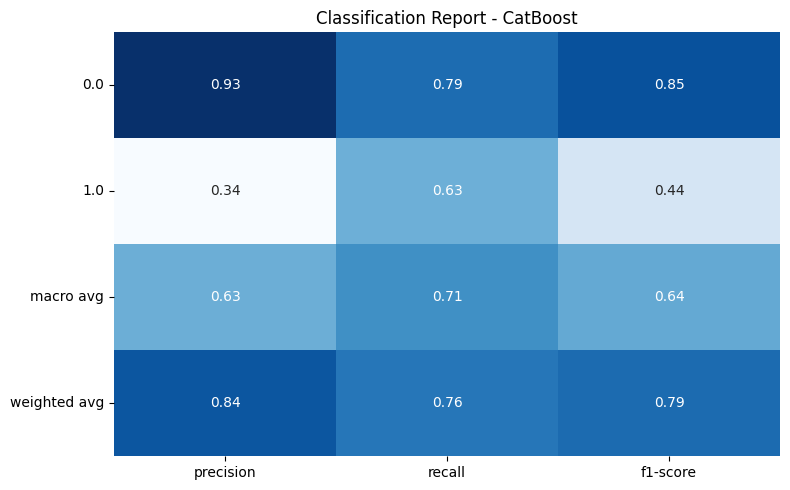

Evaluating LightGBM with SMOTE + ENN...
[LightGBM] [Info] Number of positive: 17886, number of negative: 27520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 45406, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 14308, number of negative: 22016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 36324, number

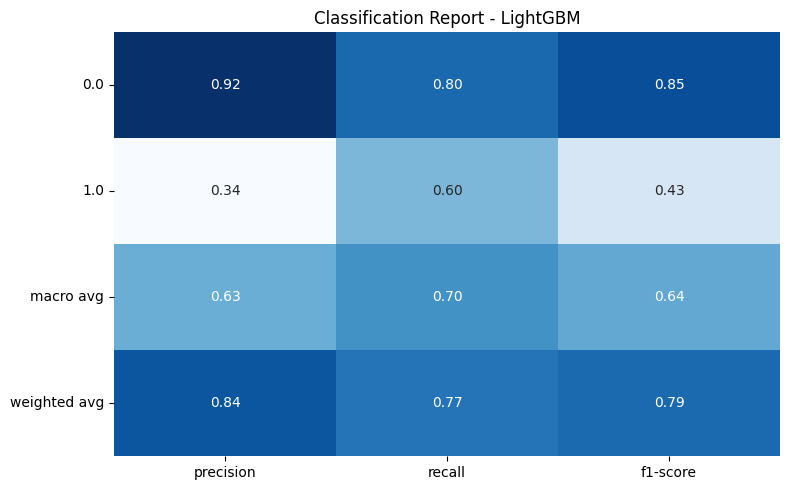

               Model  CV_Recall  Test Accuracy  Test Precision  Test F1 Score
5      Random Forest   0.951918       0.771214        0.316539       0.385077
6      Decision Tree   0.939953       0.751053        0.280646       0.346563
9           LightGBM   0.937326       0.767661        0.335324       0.431460
0               k-NN   0.926032       0.731637        0.269279       0.347791
7            XGBoost   0.918595       0.797075        0.350604       0.398039
8           CatBoost   0.889020       0.764273        0.335050       0.436723
3  Gradient Boosting   0.881751       0.756507        0.327902       0.433378
2           AdaBoost   0.844068       0.744030        0.318454       0.430305
4                LDA   0.816225       0.694291        0.286408       0.412325
1        Naive Bayes   0.787767       0.719161        0.300171       0.419471


RandomForestClassifier(random_state=123)

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize results dictionary (already initialized)
model_results = {}
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}

# Define Stratified K-Fold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Apply SMOTE + ENN on training data
smote_enn = SMOTEENN(random_state=42)
X_train_se, y_train_se = smote_enn.fit_resample(X_train, y_train)

# Loop through models, evaluate and generate classification report
for name, model in models.items():
    print(f"Evaluating {name} with SMOTE + ENN...")

    # Fit the model on resampled data
    model.fit(X_train_se, y_train_se)
    y_pred = model.predict(X_test)
    
    # Cross-validation (Recall)
    cv_score = np.mean(cross_val_score(model, X_train_se, y_train_se, cv=cv, scoring=recall_scorer))
    
    # Store evaluation results
    results['Model'].append(name)
    results['CV_Recall'].append(cv_score)
    results['Test Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Test Precision'].append(precision_score(y_test, y_pred))
    results['Test F1 Score'].append(f1_score(y_test, y_pred))
    
    # Store classification report
    model_results[name] = classification_report(y_test, y_pred)

    # Generate and display classification report heatmap
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    # # Optional: Remove 'support' and 'accuracy'
    # report_df = report_df.drop(columns=['support'], errors='ignore')
    # report_df = report_df.drop(index='accuracy', errors='ignore')

    # Plot heatmap for the current model
    plt.figure(figsize=(8, 5))
    sns.heatmap(report_df, annot=True, cmap='Blues', fmt='.2f', cbar=False)
    plt.title(f'Classification Report - {name}')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Convert results to DataFrame and sort by CV Recall
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)
print(results_df)

# Feature Importance Visualization (For best model)
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train_se, y_train_se)


## . Use Ensemble Methods or Stacking
Sometimes combining multiple models (ensemble learning) can help improve performance, especially for minority class recall.

You could try stacking or voting classifiers that combine Random Forest with other classifiers that are better at detecting the minority class.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np

# Define models
model1 = RandomForestClassifier(random_state=42)
model2 = XGBClassifier(random_state=42)
model3 = LogisticRegression(class_weight='balanced', random_state=42)

# Create the voting model
voting_model = VotingClassifier(estimators=[('rf', model1), ('xgb', model2), ('lr', model3)], voting='soft')

# Fit the model
voting_model.fit(X_train_se, y_train_se)
y_pred = voting_model.predict(X_test)

# Define cross-validation and recall scorer
cv = 5  # 5-fold cross-validation
recall_scorer = make_scorer(recall_score)

# Initialize results storage
results = {
    'Model': [],
    'CV_Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test F1 Score': []
}
model_results = {}

# Calculate and store results
cv_score = np.mean(cross_val_score(voting_model, X_train_se, y_train_se, cv=cv, scoring=recall_scorer))

# Store results
results['Model'].append('VotingClassifier')
results['CV_Recall'].append(cv_score)
results['Test Accuracy'].append(accuracy_score(y_test, y_pred))
results['Test Precision'].append(precision_score(y_test, y_pred))
results['Test F1 Score'].append(f1_score(y_test, y_pred))

# Store classification report
model_results['VotingClassifier'] = classification_report(y_test, y_pred)

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="CV_Recall", ascending=False)

# Print the results
print(results_df)
print(model_results['VotingClassifier'])


              Model  CV_Recall  Test Accuracy  Test Precision  Test F1 Score
0  VotingClassifier   0.941751        0.76386        0.324003       0.413383
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.85     10339
         1.0       0.32      0.57      0.41      1764

    accuracy                           0.76     12103
   macro avg       0.62      0.68      0.63     12103
weighted avg       0.83      0.76      0.79     12103



## XAI 

## Permutation Importance¶


In [13]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

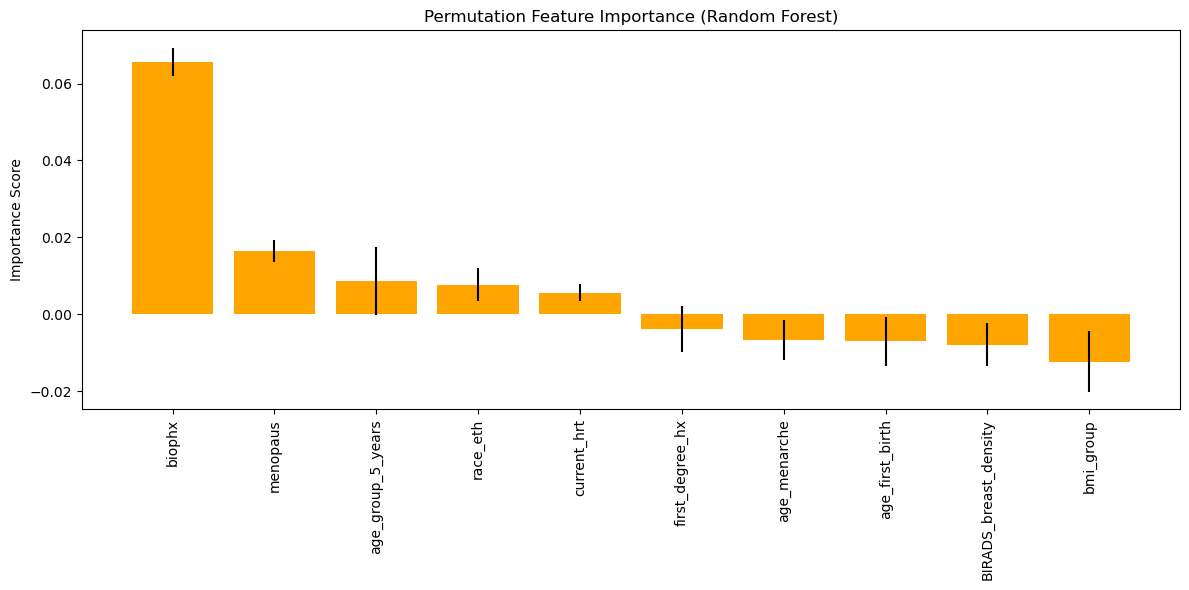

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Fit the RandomForest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 2: Evaluate permutation importance on the test set
result = permutation_importance(
    rf_model, X_test, y_test,
    n_repeats=10,               # number of shuffles
    random_state=42,
    scoring='recall'          # or 'f1', 'recall', etc.
)

# Step 3: Get importance means and sort them
importances = result.importances_mean
stds = result.importances_std
indices = np.argsort(importances)[::-1]

# Step 4: Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Permutation Feature Importance (Random Forest)")
plt.bar(range(X_test.shape[1]), importances[indices], yerr=stds[indices], align="center",color="orange")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation=90)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


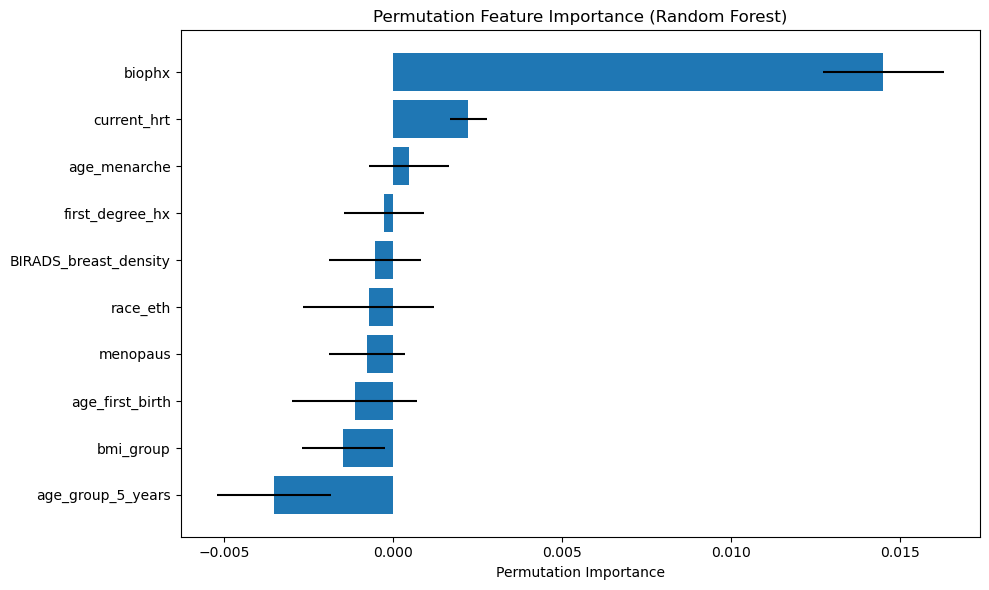

In [15]:
from sklearn.inspection import permutation_importance

# Fit your Random Forest model first
rf_model.fit(X_train, y_train)

# Calculate permutation importance
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Plotting
import matplotlib.pyplot as plt
import numpy as np

importance = result.importances_mean
std = result.importances_std
features = X_test.columns

sorted_idx = np.argsort(importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(importance)), importance[sorted_idx], xerr=std[sorted_idx], align="center")
plt.yticks(range(len(importance)), features[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


## LIME

In [16]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Train your model and ensure X_train and X_test are NumPy arrays
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['No disease', 'Disease'],
    discretize_continuous=True,
    mode='classification'
)

# Choose a test sample to explain
i = 1
exp = explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=rf_model.predict_proba  # Use your trained model's predict_proba method
)

print('Reference:', y_test.iloc[i])
# print('Predicted:', predictions[i])

# Show explanation in notebook (or export as HTML/text if needed)
exp.show_in_notebook()


Reference: 0.0


c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [17]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Train your model and ensure X_train and X_test are NumPy arrays
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['No disease', 'Disease'],
    discretize_continuous=True,
    mode='classification'
)

# Choose a test sample to explain
row_index=28
exp = explainer.explain_instance(X_test.iloc[row_index], model.predict_proba, num_features=10)



# Show explanation in notebook (or export as HTML/text if needed)
exp.show_in_notebook()


c:\Users\waelw\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\waelw\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\waelw\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

In [18]:
row_index=df[df['breast_cancer_history']==1]
row_index

age_group_5_years  race_eth  first_degree_hx  age_menarche  \
5                      9       1.0              0.0           1.0   
21                     9       1.0              0.0           1.0   
23                    13       3.0              0.0           1.0   
28                     9       1.0              1.0           0.0   
29                     6       5.0              0.0           2.0   
...                  ...       ...              ...           ...   
60480                  8       1.0              0.0           0.0   
60493                  7       1.0              0.0           1.0   
60496                  8       2.0              0.0           1.0   
60498                  8       3.0              0.0           1.0   
60501                  5       2.0              0.0           1.0   

       age_first_birth  BIRADS_breast_density  current_hrt  menopaus  \
5                  2.0                    4.0          0.0       2.0   
21                 2.0                    1.0          0.0       2.0   
23                 3.0                    4.0          0.0       2.0   
28                 4.0                    2.0          0.0       2.0   
29                 2.0                    2.0          0.0       2.0   
...                ...                    ...          ...       ...   
60480              0.0                    2.0          0.0       2.0   
60493              2.0                    3.0          0.0       2.0   
60496              4.0                    3.0          0.0       2.0   
60498              2.0                    3.0          1.0       2.0   
60501              2.0                    3.0          0.0       3.0   

       bmi_group  biophx  breast_cancer_history  
5            2.0     0.0                    1.0  
21           3.0     1.0                    1.0  
23           1.0     1.0                    1.0  
28           3.0     1.0                    1.0  
29           3.0     1.0                    1.0  
...          ...     ...                    ...  
60480        2.0     1.0                    1.0  
60493        3.0     0.0                    1.0  
60496        3.0     0.0                    1.0  
60498        1.0     0.0                    1.0  
60501        3.0     1.0                    1.0  

[8821 rows x 11 columns]

age_group_5_years  race_eth  first_degree_hx  age_menarche  \
5                      9       1.0              0.0           1.0   
21                     9       1.0              0.0           1.0   
23                    13       3.0              0.0           1.0   
28                     9       1.0              1.0           0.0   
29                     6       5.0              0.0           2.0   
...                  ...       ...              ...           ...   
60480                  8       1.0              0.0           0.0   
60493                  7       1.0              0.0           1.0   
60496                  8       2.0              0.0           1.0   
60498                  8       3.0              0.0           1.0   
60501                  5       2.0              0.0           1.0   

       age_first_birth  BIRADS_breast_density  current_hrt  menopaus  \
5                  2.0                    4.0          0.0       2.0   
21                 2.0                    1.0          0.0       2.0   
23                 3.0                    4.0          0.0       2.0   
28                 4.0                    2.0          0.0       2.0   
29                 2.0                    2.0          0.0       2.0   
...                ...                    ...          ...       ...   
60480              0.0                    2.0          0.0       2.0   
60493              2.0                    3.0          0.0       2.0   
60496              4.0                    3.0          0.0       2.0   
60498              2.0                    3.0          1.0       2.0   
60501              2.0                    3.0          0.0       3.0   

       bmi_group  biophx  breast_cancer_history  
5            2.0     0.0                    1.0  
21           3.0     1.0                    1.0  
23           1.0     1.0                    1.0  
28           3.0     1.0                    1.0  
29           3.0     1.0                    1.0  
...          ...     ...                    ...  
60480        2.0     1.0                    1.0  
60493        3.0     0.0                    1.0  
60496        3.0     0.0                    1.0  
60498        1.0     0.0                    1.0  
60501        3.0     1.0                    1.0  

[8821 rows x 11 columns]

## SHAP

In [10]:
import shap
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
import joblib
import matplotlib.pyplot as plt

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Summarize background dataset to speed up SHAP calculations
X_train_summary = shap.sample(X_train, 100, random_state=42)

# Initialize SHAP KernelExplainer
# Use a wrapper to extract class 1 probability for binary classification
def predict_proba_class1(X):
    return model.predict_proba(X)[:, 1]  # Probability for class 1 (breast cancer)

explainer = shap.KernelExplainer(predict_proba_class1, X_train_summary)

# Subsample test set for SHAP calculation
X_sample = X_test.iloc[:100]

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# Debug: Check shape of shap_values
print("Shape of shap_values:", shap_values.shape)
print("Number of columns in X_sample:", len(X_sample.columns))
print("X_sample columns:", X_sample.columns.tolist())

# Plot SHAP summary (bar plot)
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.savefig('shap_summary_plot.png')
plt.close()

# Compute mean absolute SHAP values
shap_importance = np.abs(shap_values).mean(axis=0)

# Debug: Check length of shap_importance
print("Length of shap_importance:", len(shap_importance))

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': shap_importance
}).sort_values(by='Importance', ascending=False)

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)

# Identify non-important features (bottom 20%)
threshold = feature_importance['Importance'].quantile(0.2)
non_important_features = feature_importance[feature_importance['Importance'] < threshold]['Feature'].tolist()
print("Non-important features:", non_important_features)

# Drop non-important features from training and test sets
X_train_reduced = X_train.drop(columns=non_important_features)
X_test_reduced = X_test.drop(columns=non_important_features)

# Retrain Random Forest model on reduced dataset
model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Evaluate performance on test set
y_pred_reduced = model_reduced.predict(X_test_reduced)
print("Reduced Model Performance (Random Forest):")
print(f"Recall: {recall_score(y_test, y_pred_reduced):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_reduced):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_reduced):.4f}")

# Save model and feature list
joblib.dump(model_reduced, 'reduced_model.pkl')
joblib.dump(X_train_reduced.columns.tolist(), 'model_columns.pkl')

c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\waelw\anaconda3\Lib\site-packages\sklearn\base.py:4

Shape of shap_values: (100, 10)
Number of columns in X_sample: 10
X_sample columns: ['age_group_5_years', 'race_eth', 'first_degree_hx', 'age_menarche', 'age_first_birth', 'BIRADS_breast_density', 'current_hrt', 'menopaus', 'bmi_group', 'biophx']
Length of shap_importance: 10
Non-important features: ['first_degree_hx', 'current_hrt']
Reduced Model Performance (Random Forest):
Recall: 0.1241
Accuracy: 0.8330
Precision: 0.3151
F1 Score: 0.1781


['model_columns.pkl']

In [11]:
metrics = {
    'Metric': ['Recall', 'Accuracy', 'Precision', 'F1 Score'],
    'Value': [
        recall_score(y_test, y_pred_reduced),
        accuracy_score(y_test, y_pred_reduced),
        precision_score(y_test, y_pred_reduced),
        f1_score(y_test, y_pred_reduced)
    ]
}
metrics_df = pd.DataFrame(metrics)

# Display metrics with background gradient
print("\nReduced Model Performance (Random Forest):")
display(metrics_df.style.background_gradient(cmap='bwr', axis=0, subset=['Value']).format({'Value': '{:.4f}'}))



Reduced Model Performance (Random Forest):


In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
from imblearn.combine import SMOTEENN
import joblib
from IPython.display import display

# Define Stratified K-Fold and scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

# Apply SMOTE + ENN to training data
smote_enn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)

# Initialize Random Forest model (match original random_state)
model = RandomForestClassifier(random_state=123)  # Align with original code

# Cross-validation (Recall)
cv_recall = np.mean(cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring=recall_scorer))

# Train the model
model.fit(X_train_balanced, y_train_balanced)

# Evaluate on test set
y_pred = model.predict(X_test)

# Create a DataFrame for metrics
metrics = {
    'Metric': ['CV Recall', 'Test Recall', 'Test Accuracy', 'Test Precision', 'Test F1 Score'],
    'Value': [
        cv_recall,
        recall_score(y_test, y_pred),
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ]
}
metrics_df = pd.DataFrame(metrics)

# Display metrics with background gradient
print("\nFull Model Performance (Random Forest with SMOTE + ENN):")
display(metrics_df.style.background_gradient(cmap='bwr', axis=0, subset=['Value']).format({'Value': '{:.4f}'}))

# Save model and feature list
joblib.dump(model, 'full_model.pkl')
joblib.dump(X_train_balanced.columns.tolist(), 'model_columns.pkl')


Full Model Performance (Random Forest with SMOTE + ENN):


['model_columns.pkl']